In [1]:
import os
import ConfigParser
Config = ConfigParser.ConfigParser()
Config.read("/home/bilab/nacsi_root/config/config.txt")
gpu_num = int(Config.get('global', 'gpu_num'))

room_no = int(os.path.basename(os.getcwd()).split('_')[1])
allocated_gpu = room_no % gpu_num

print "using gpu no : %d" % allocated_gpu
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda%d,floatX=float32" % allocated_gpu

import theano

using gpu no : 7


Using cuDNN version 5103 on context None
Mapped name None to device cuda7: Graphics Device (0000:1C:00.0)


In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
% pylab inline

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, Conv2DTranspose, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K

K.set_image_dim_ordering('th')

Populating the interactive namespace from numpy and matplotlib


Using Theano backend.


  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 300
Batch size: 128
Batches per epoch: 468


100%|██████████| 468/468 [00:02<00:00, 194.06it/s]
/usr/lib/pymodules/python2.7/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)
100%|██████████| 468/468 [00:02<00:00, 168.27it/s]


100%|██████████| 468/468 [00:02<00:00, 171.07it/s]


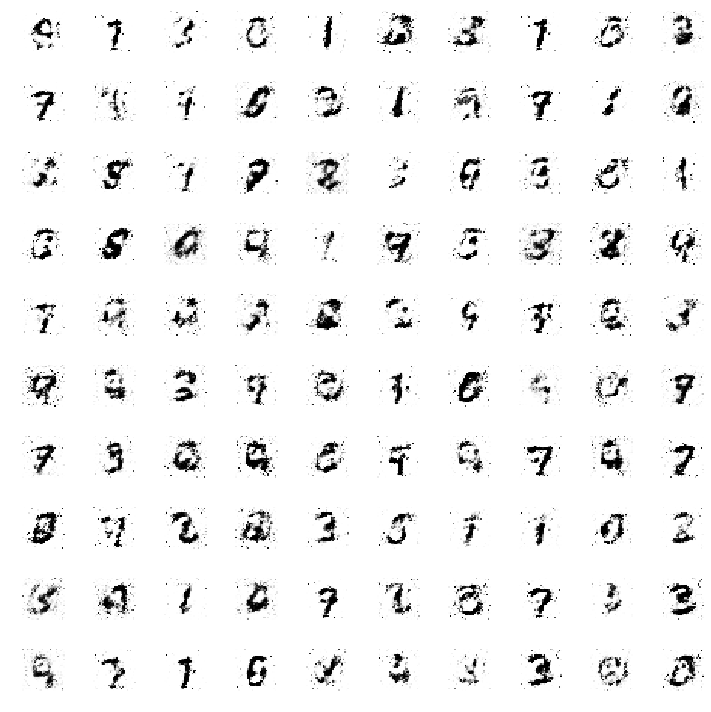

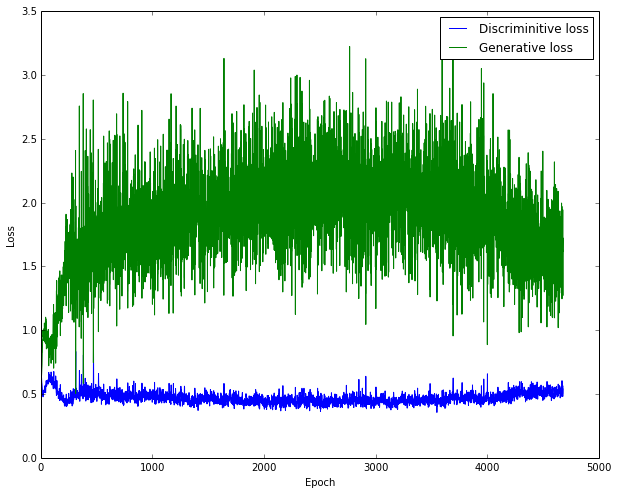

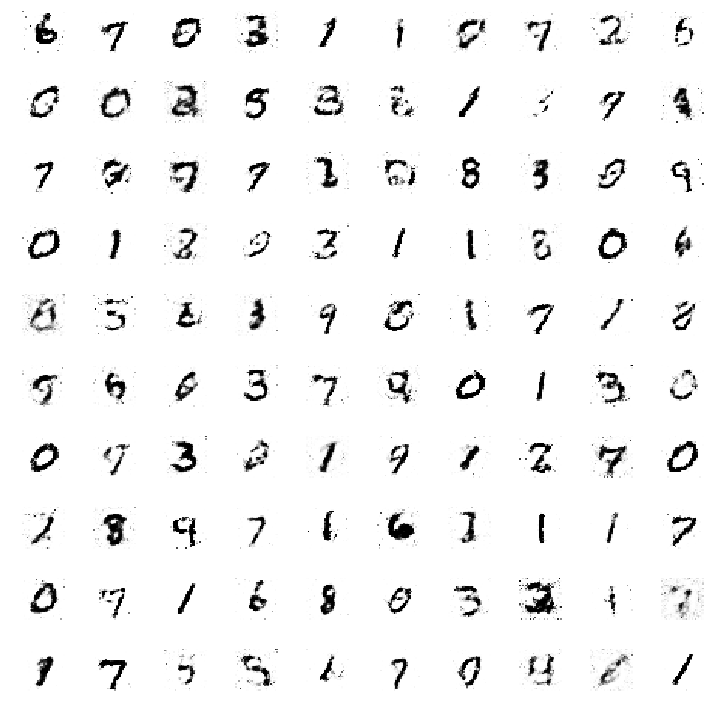

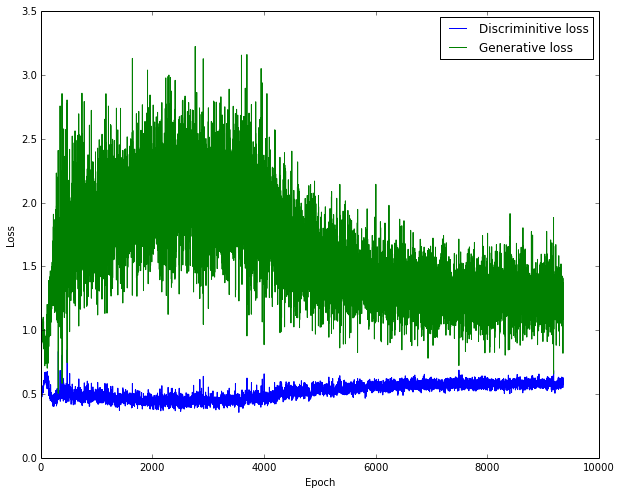

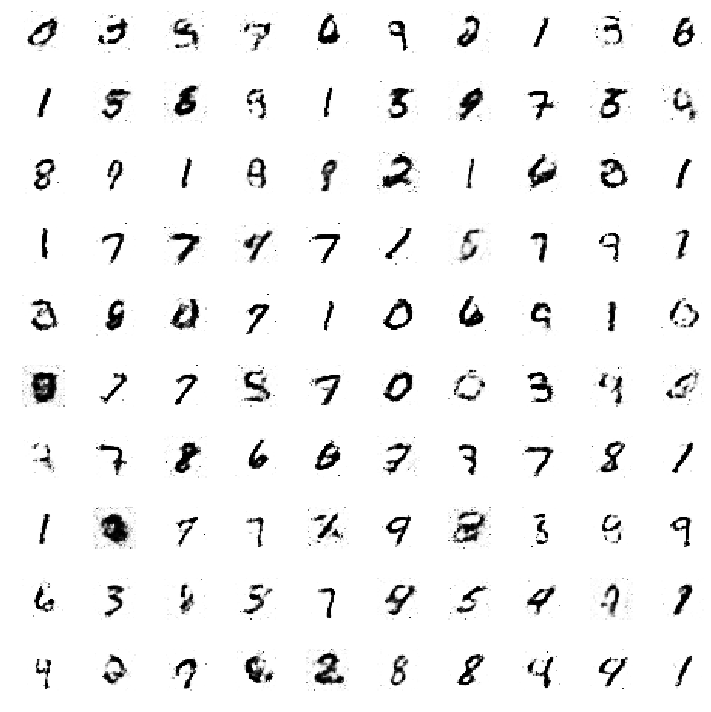

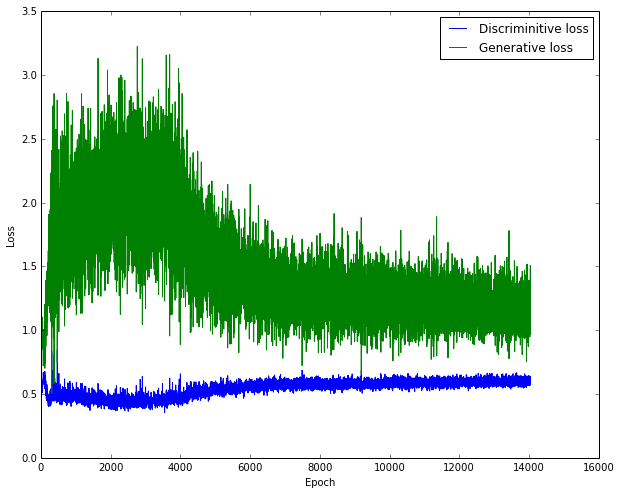

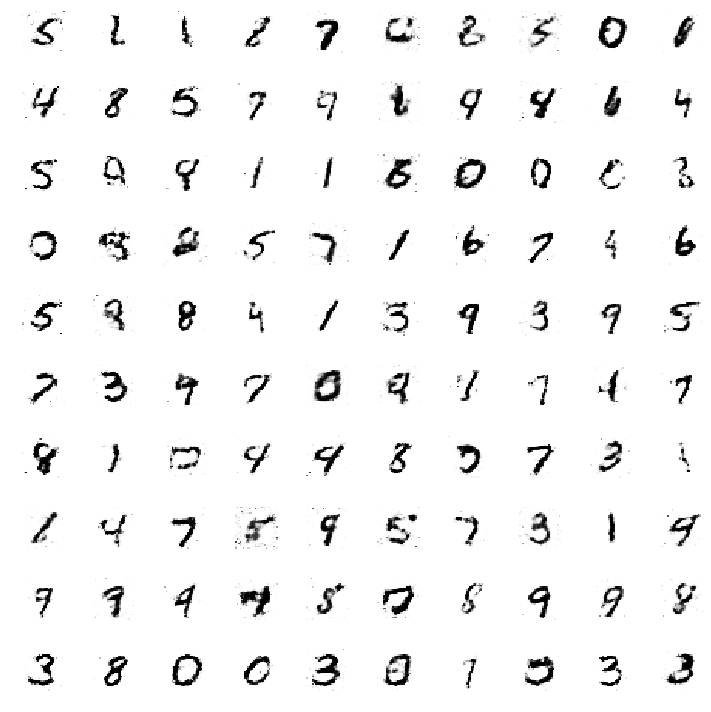

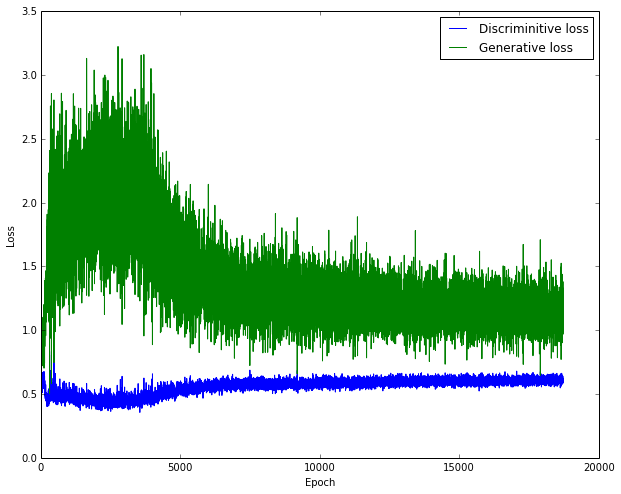

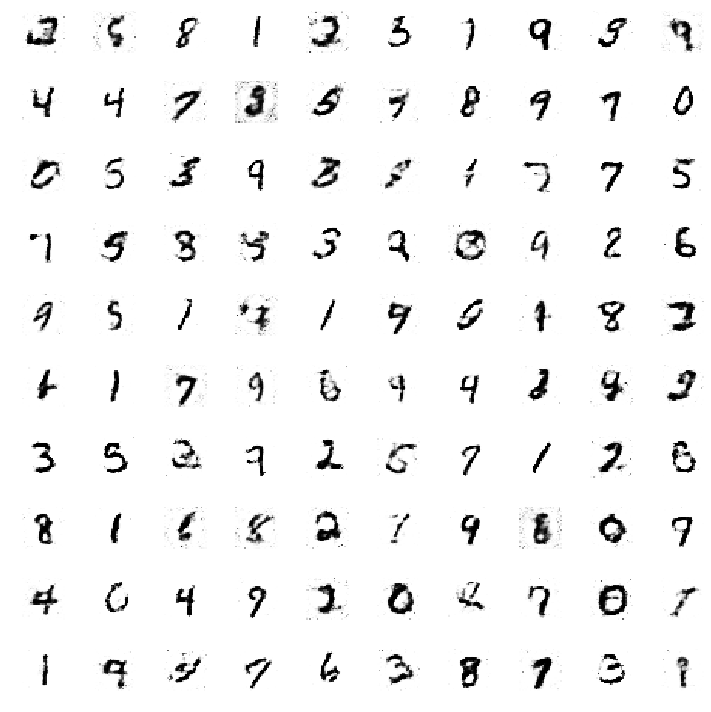

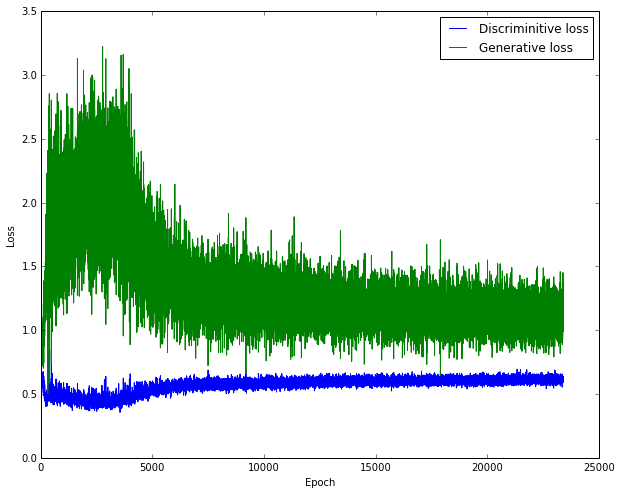

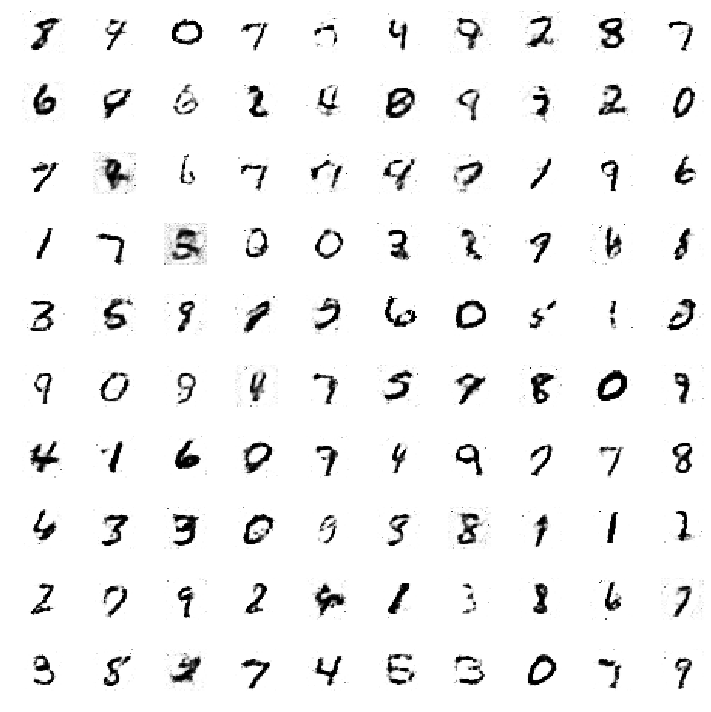

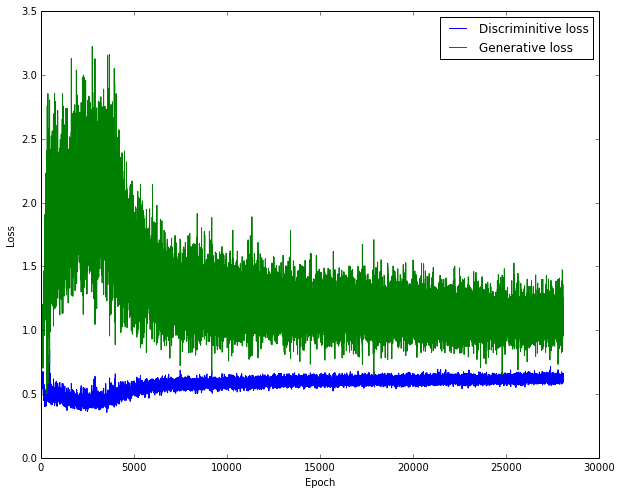

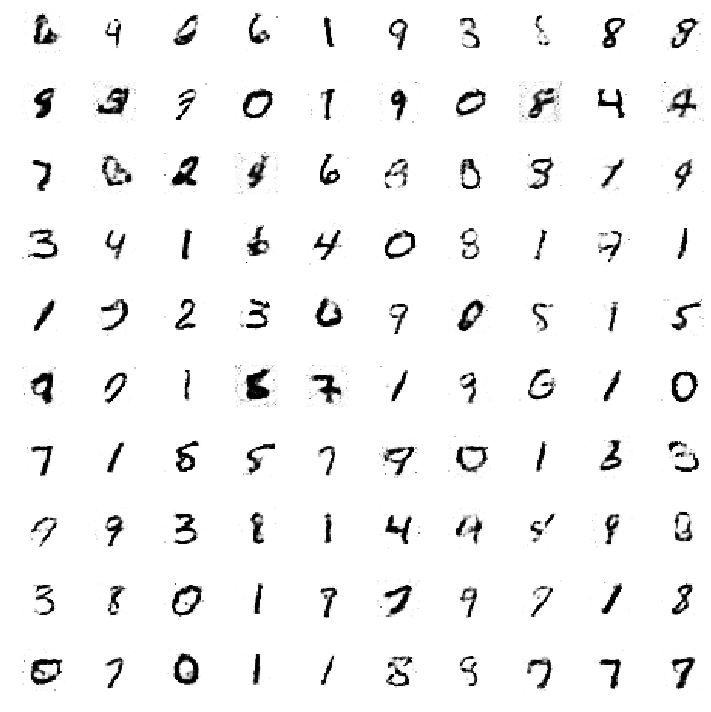

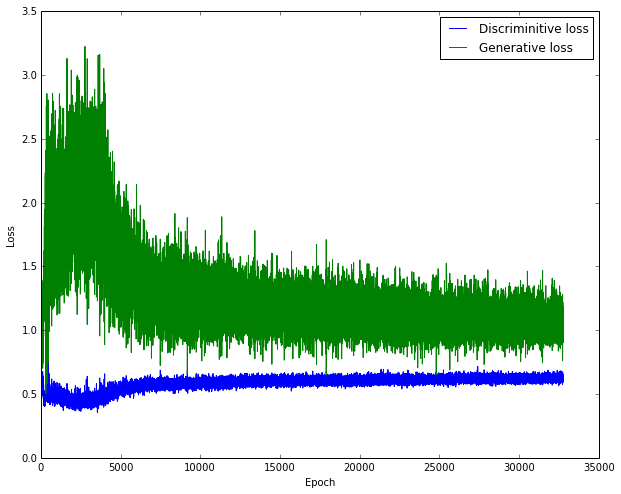

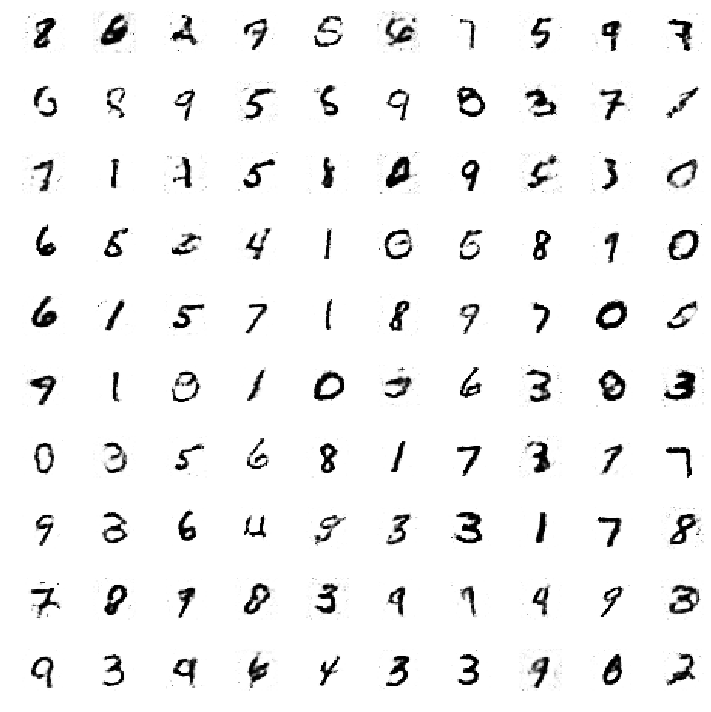

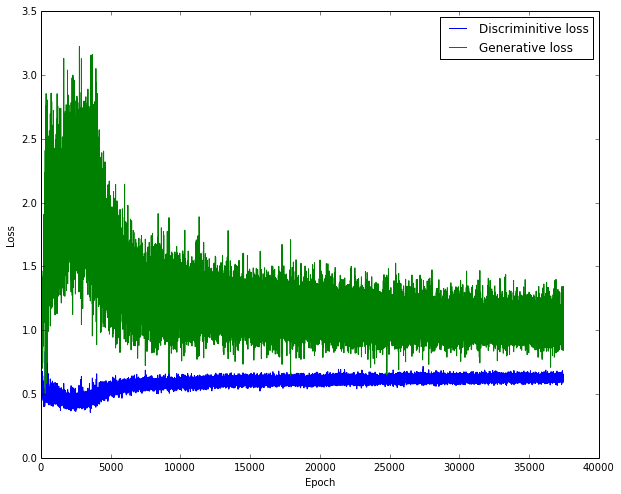

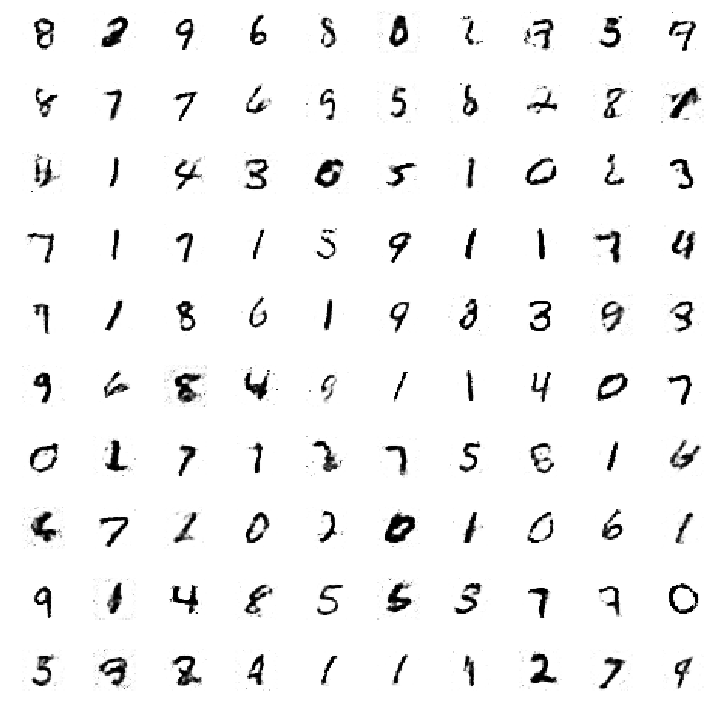

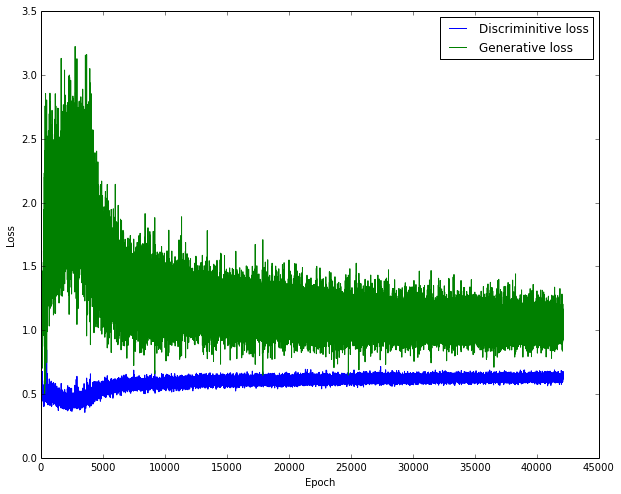

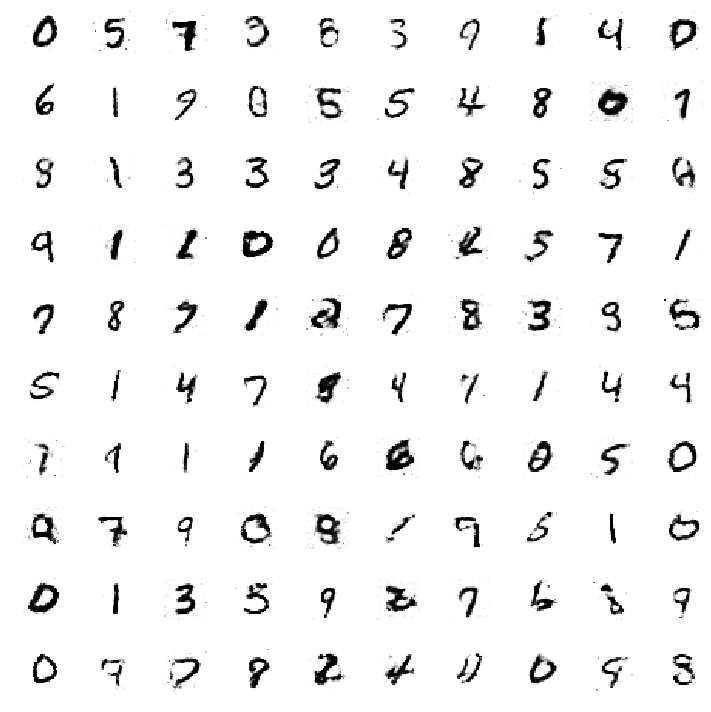

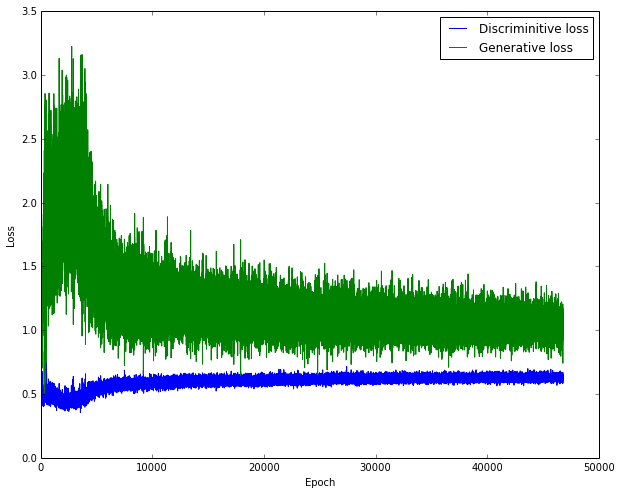

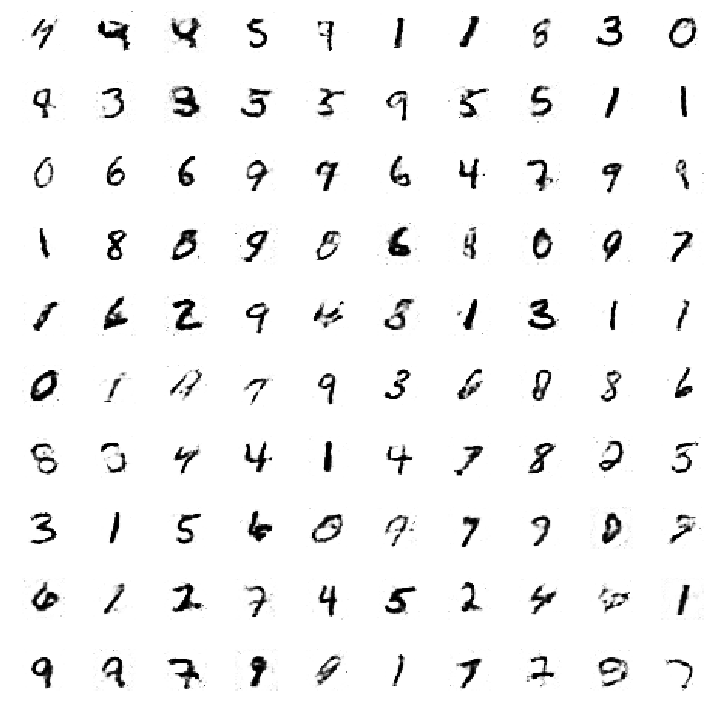

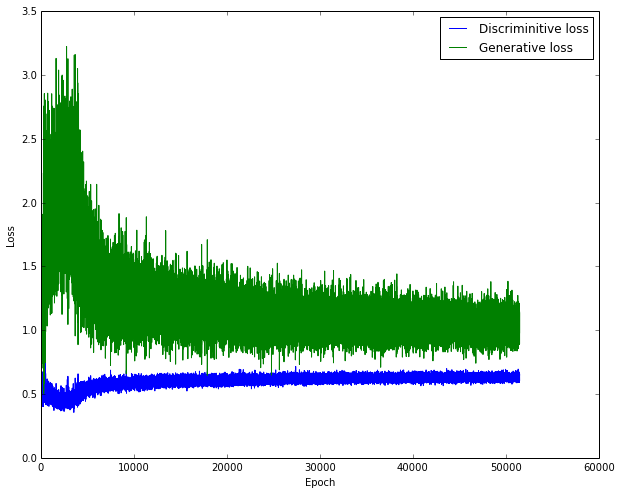

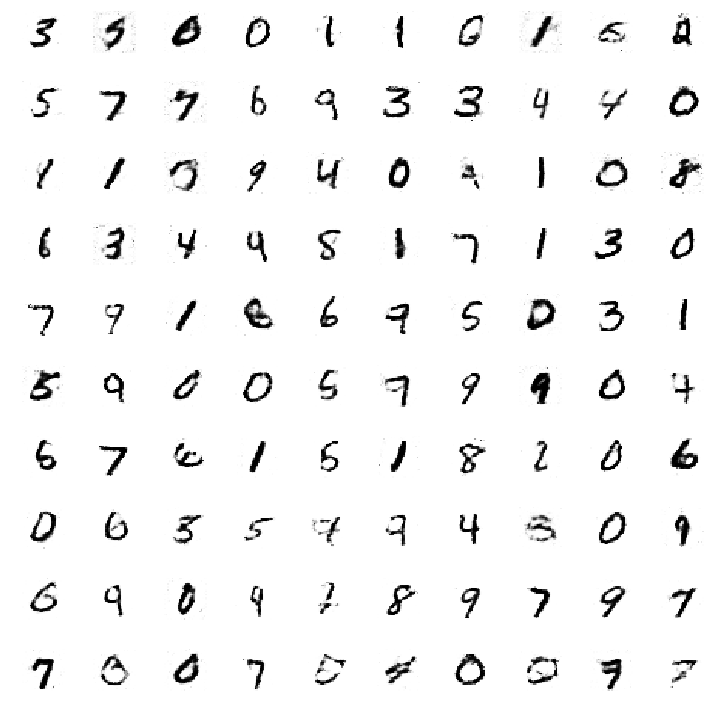

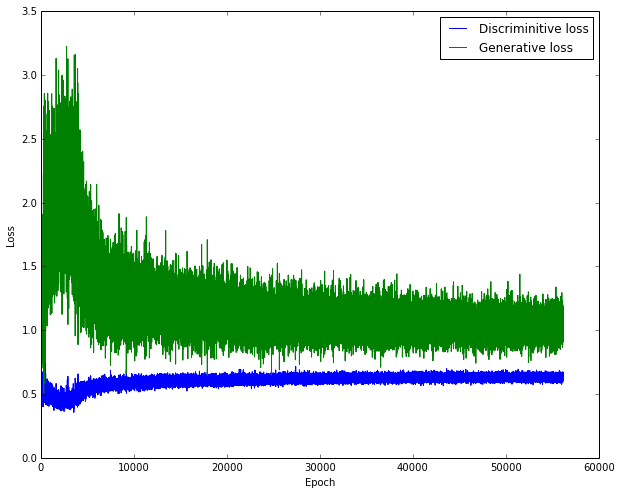

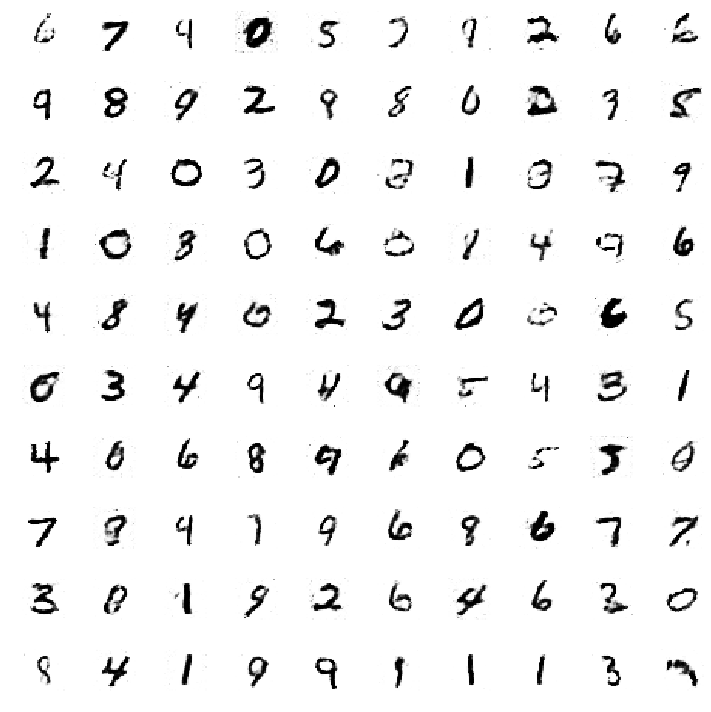

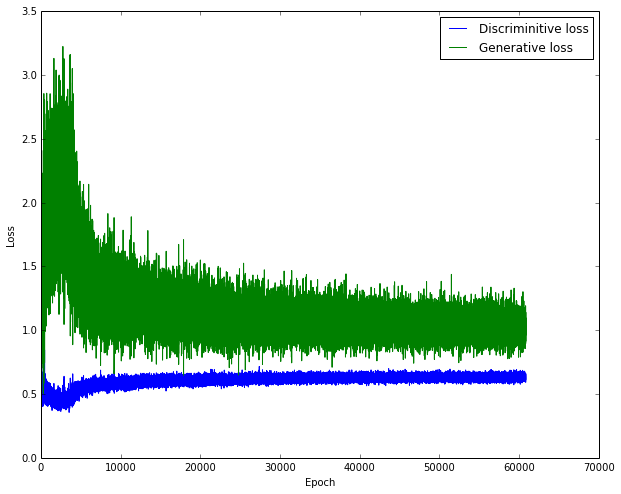

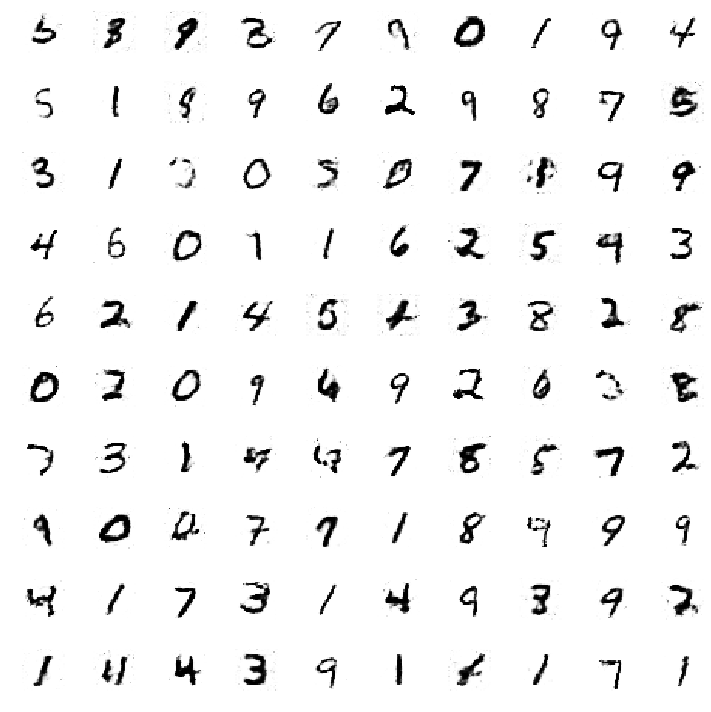

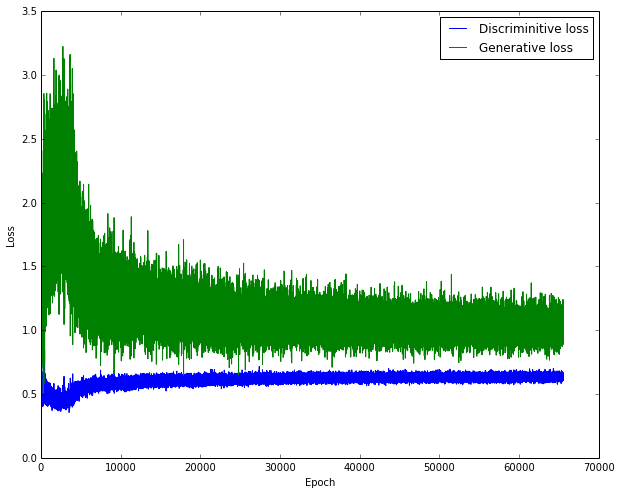

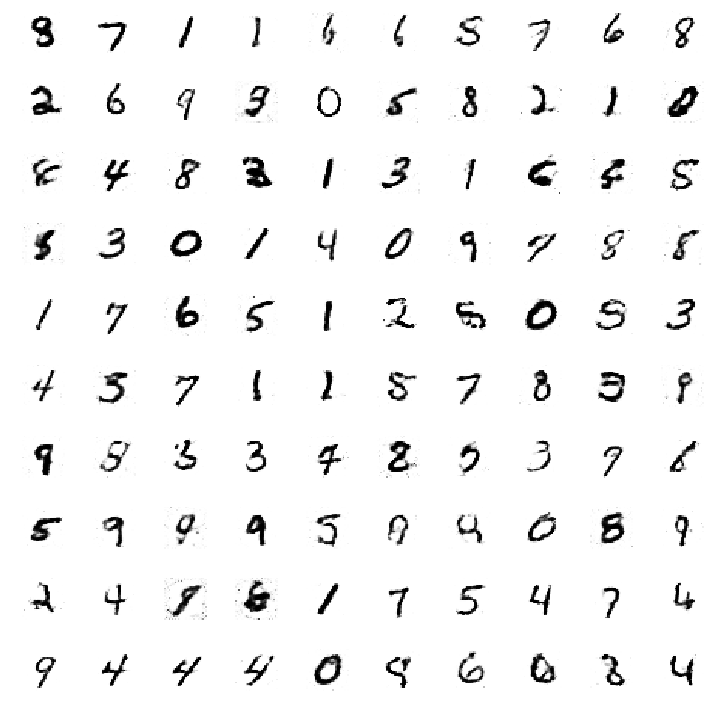

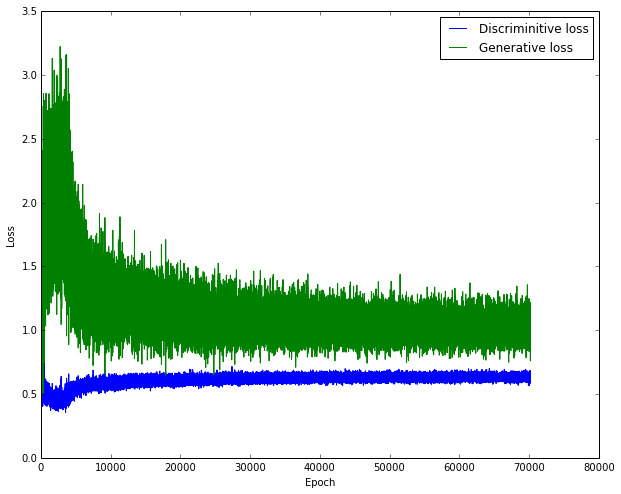

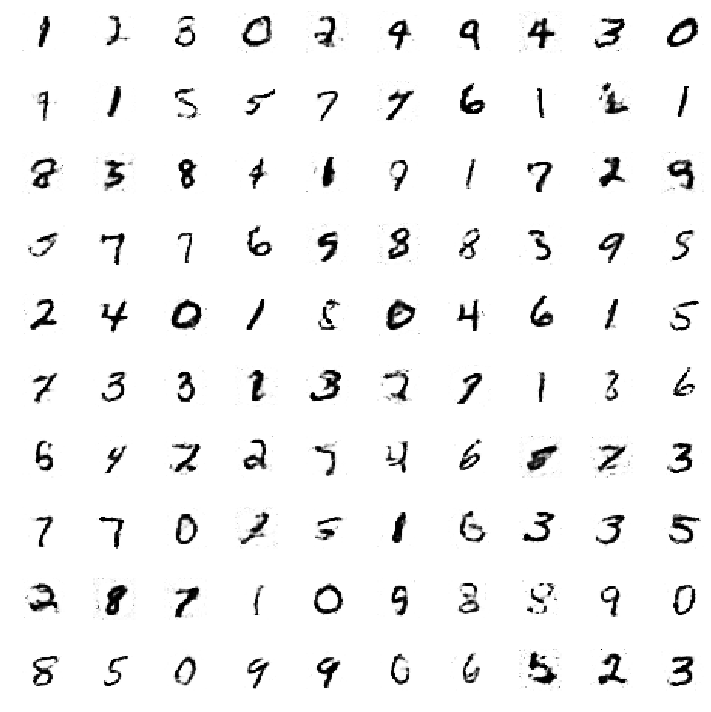

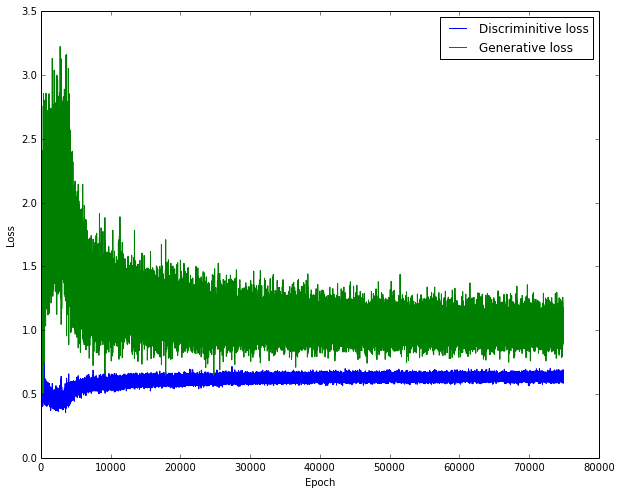

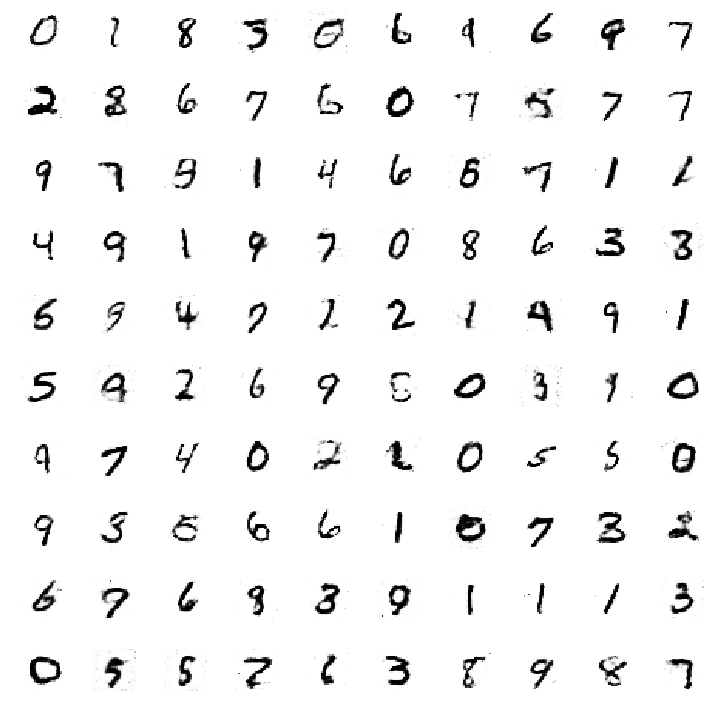

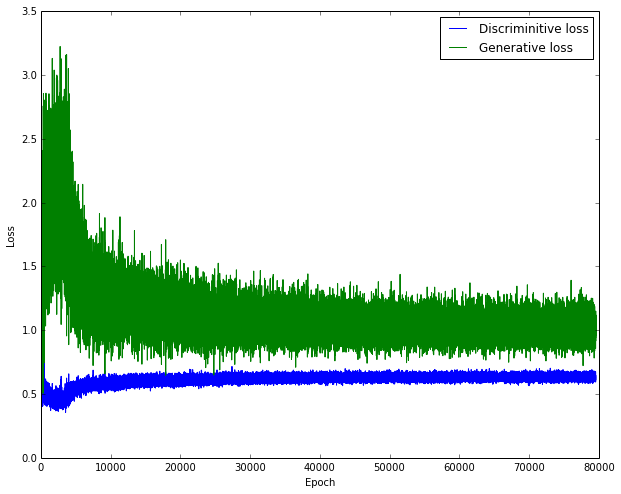

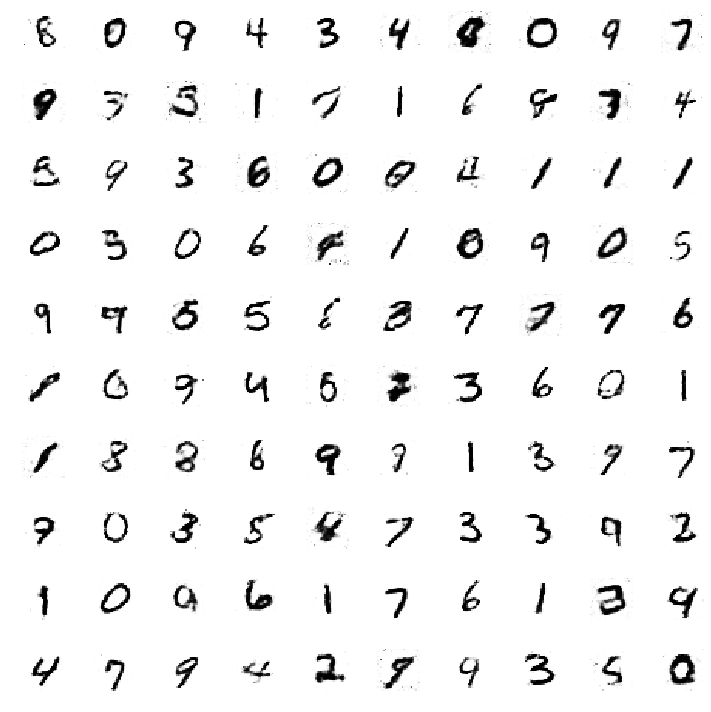

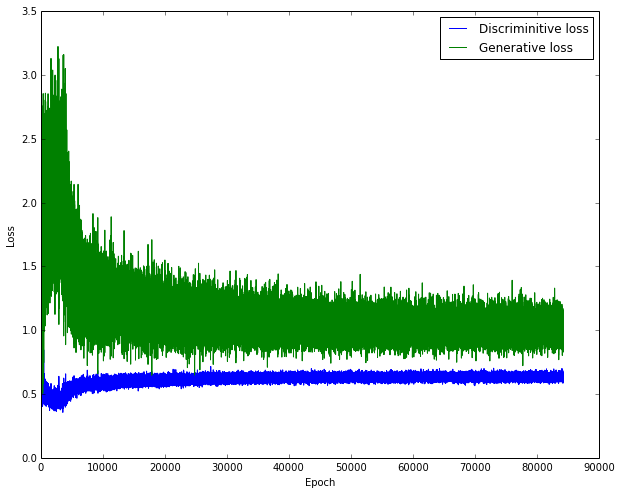

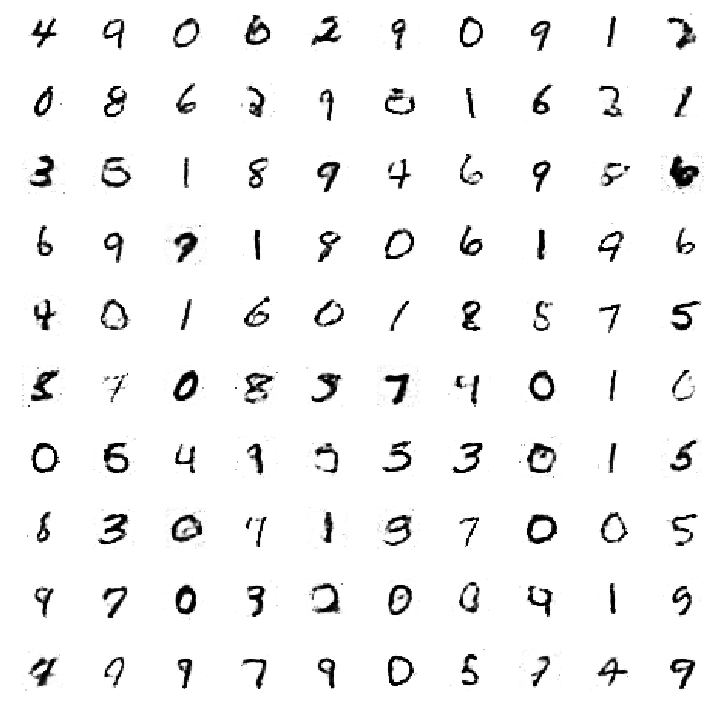

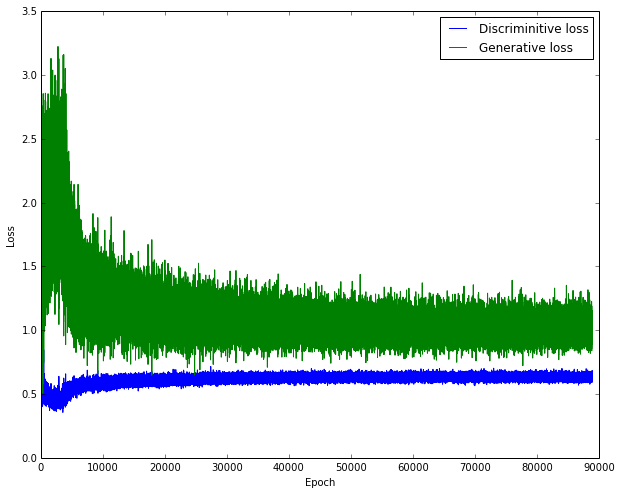

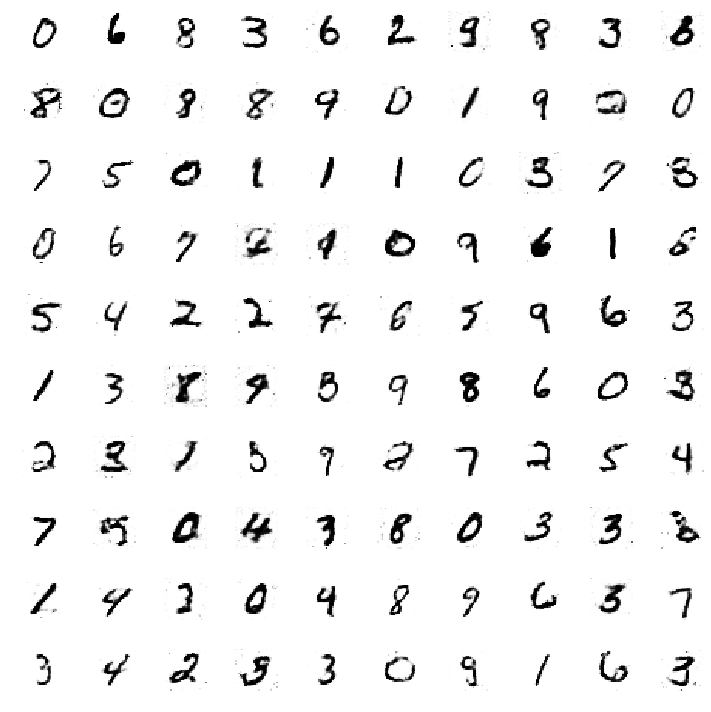

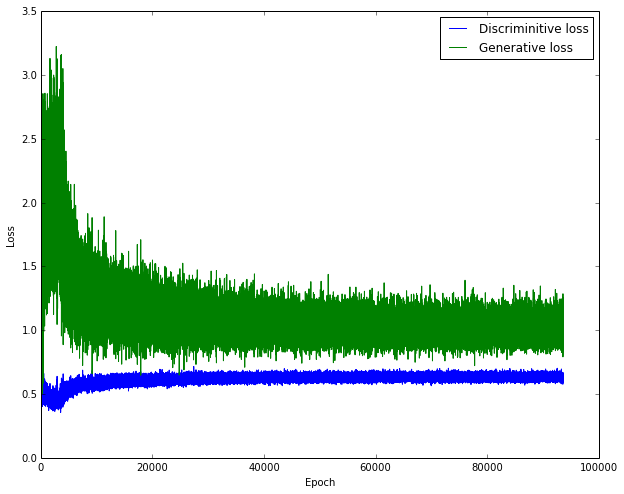

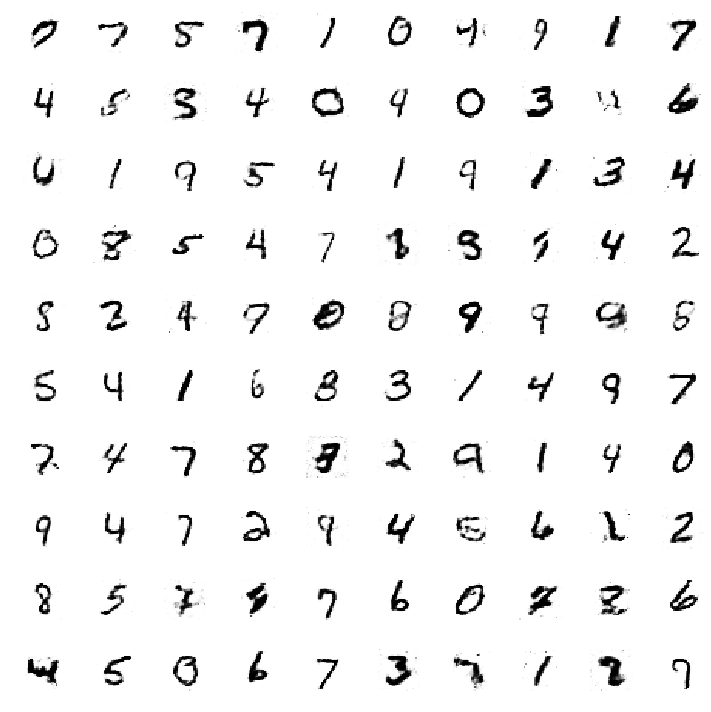

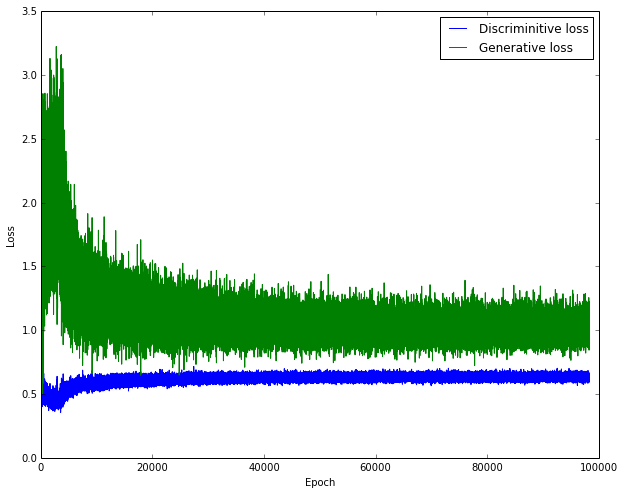

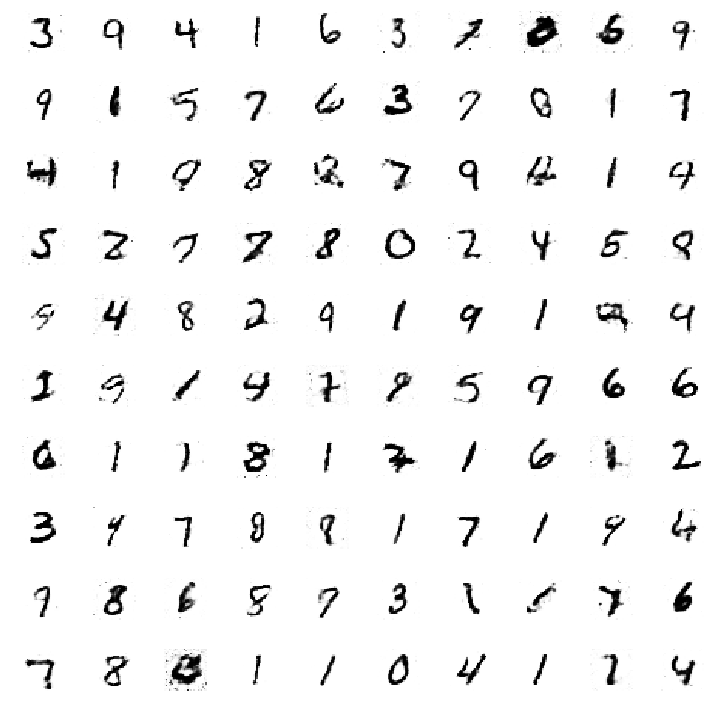

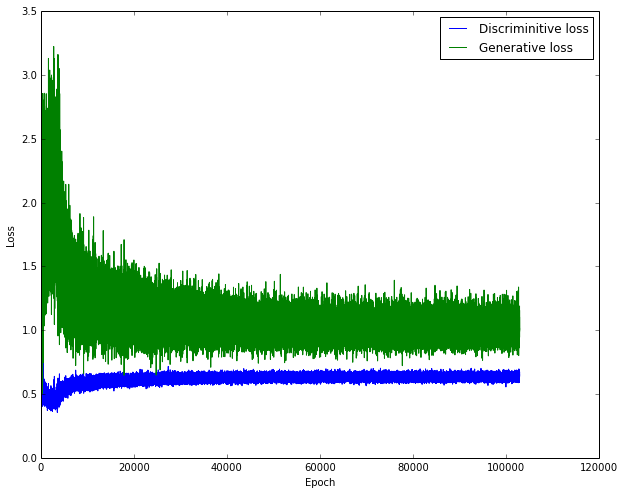

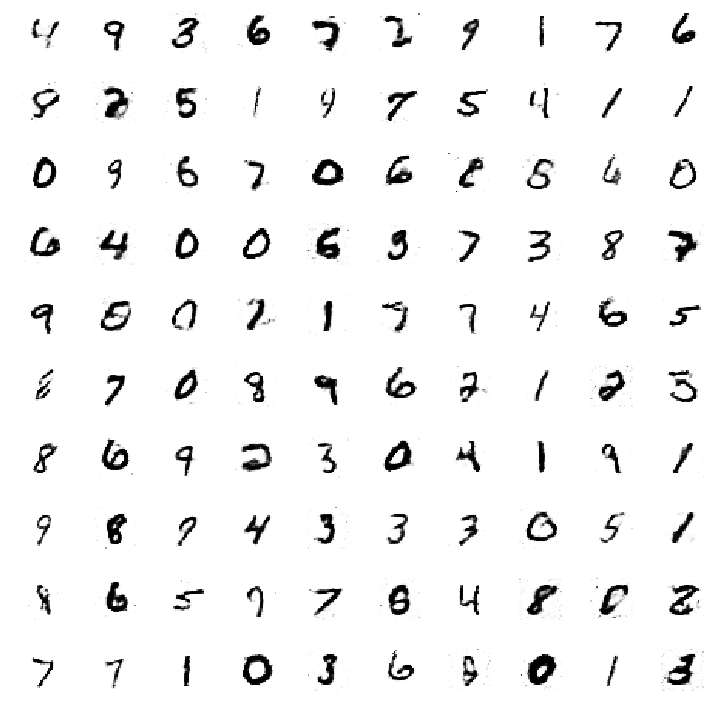

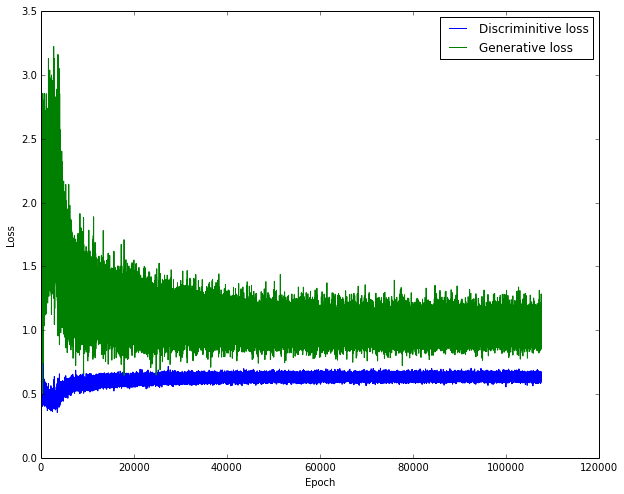

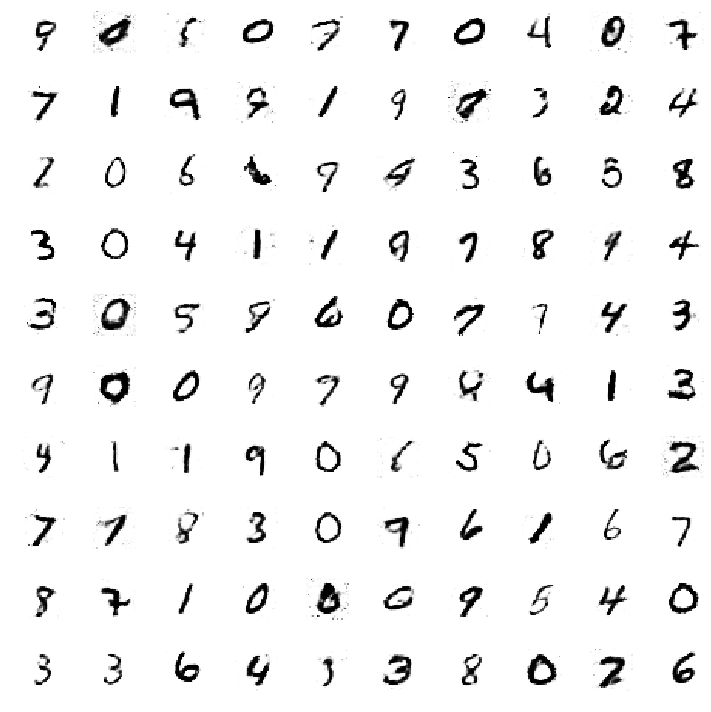

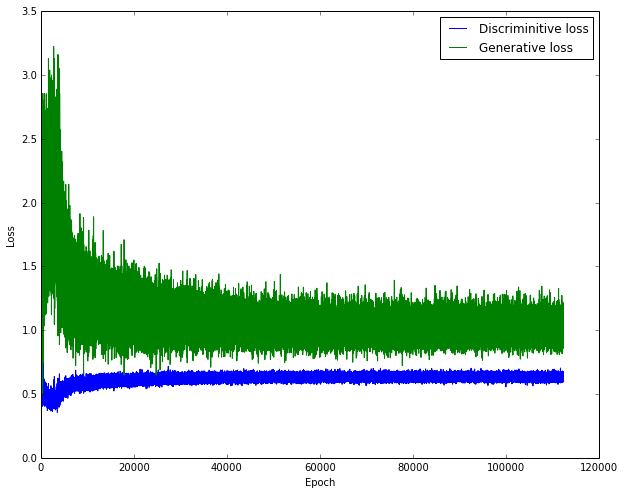

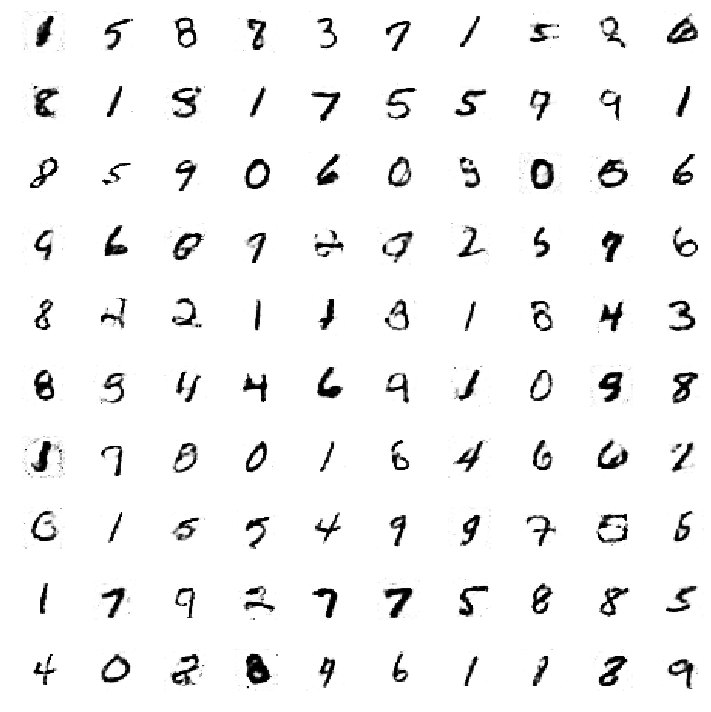

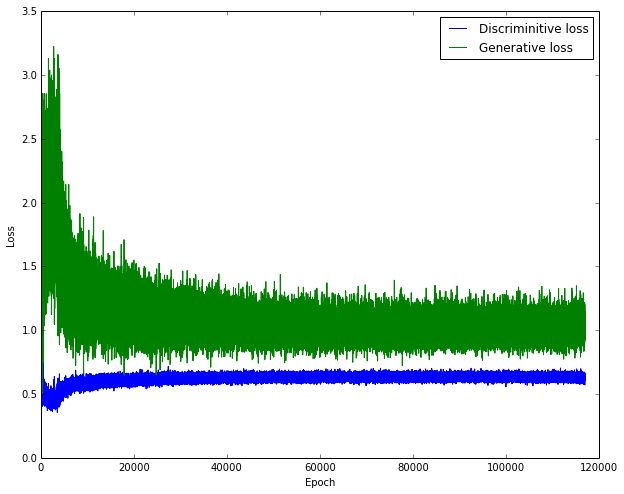

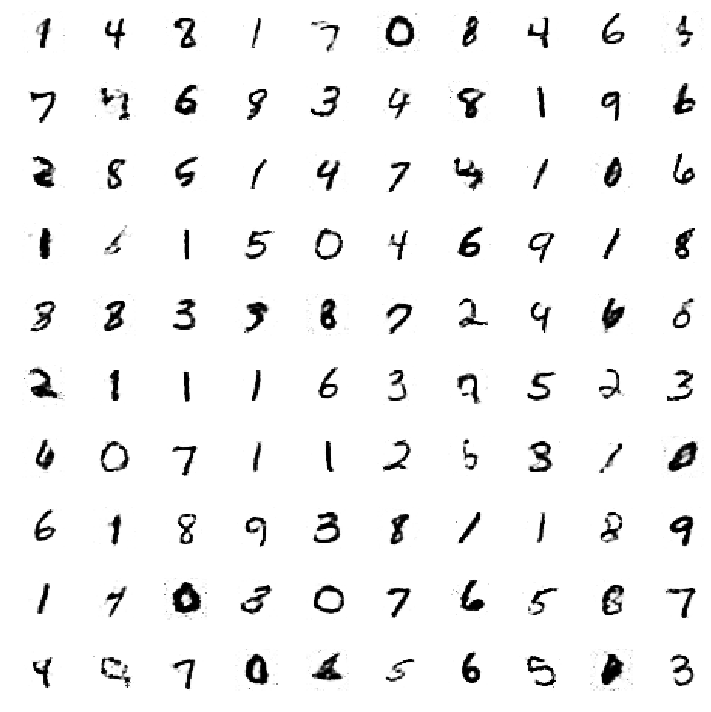

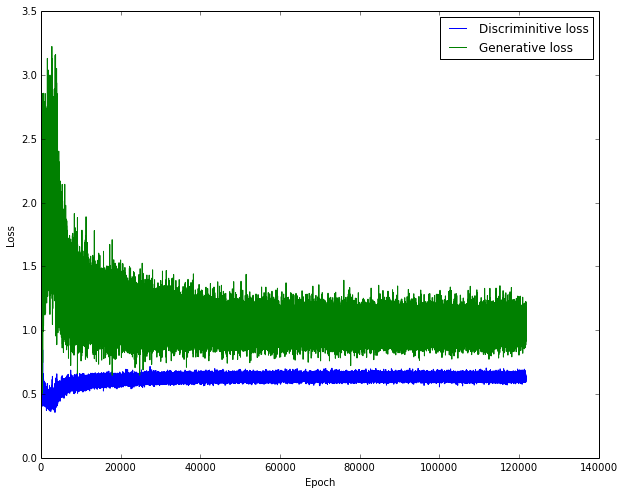

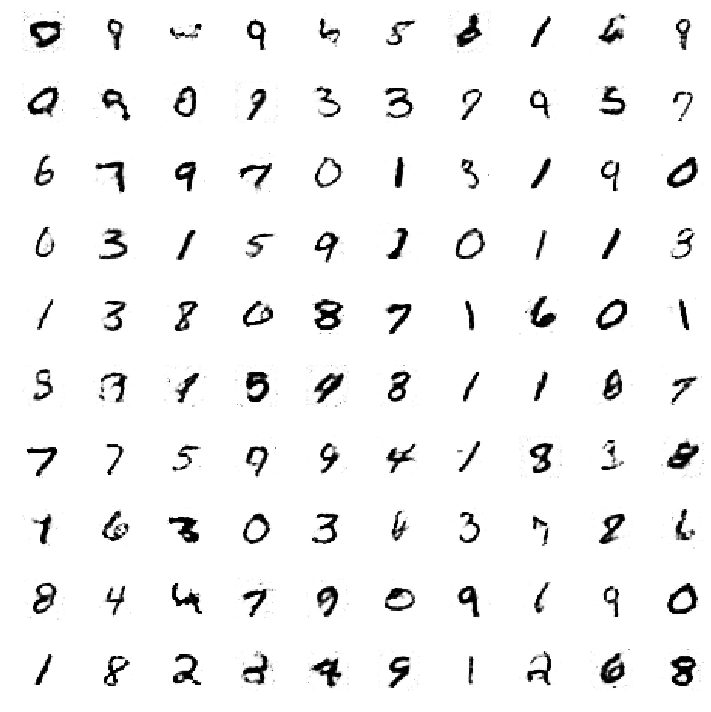

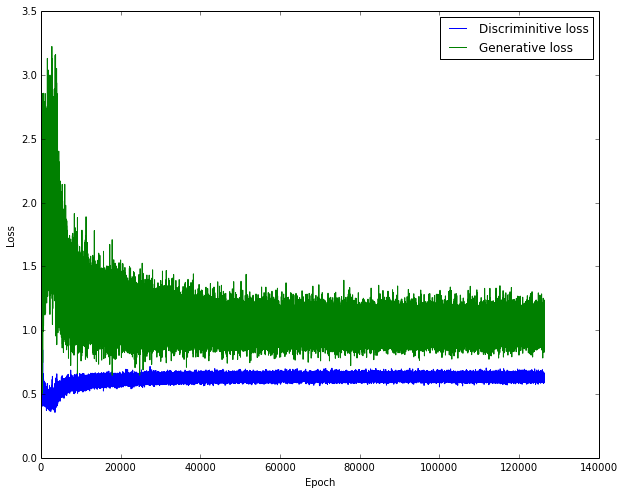

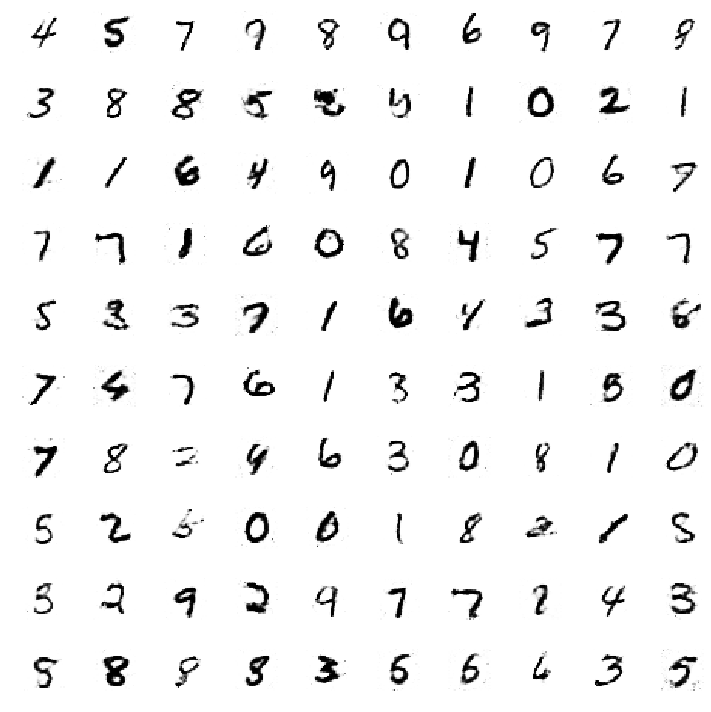

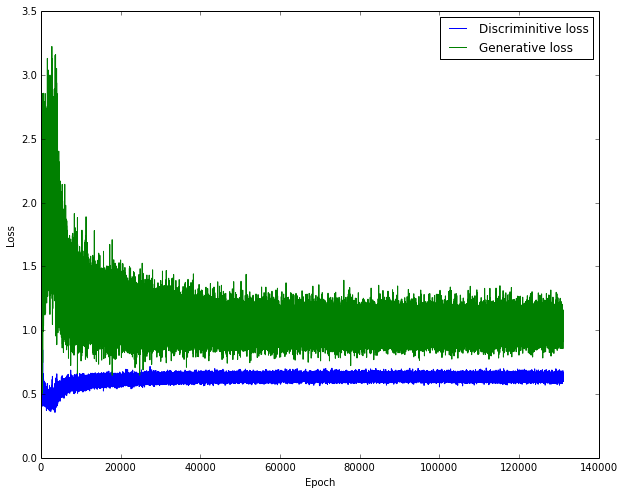

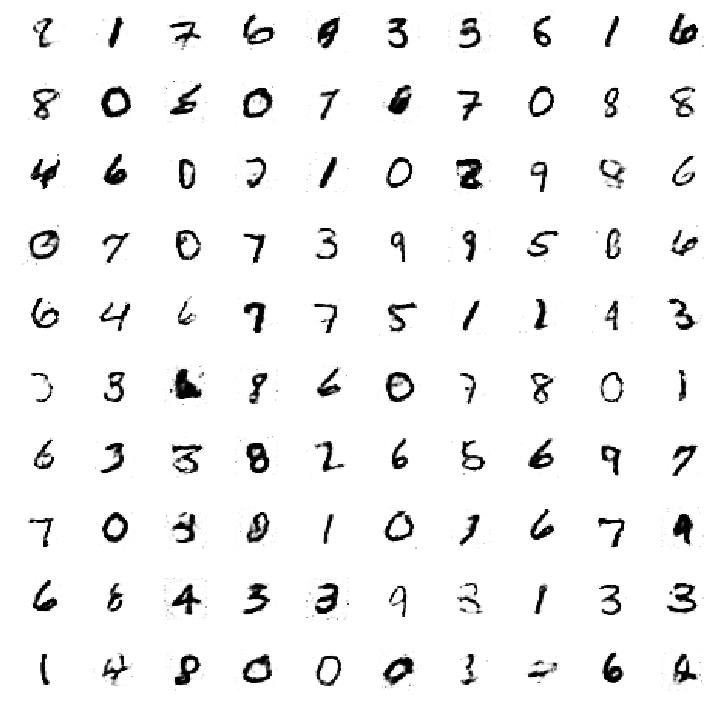

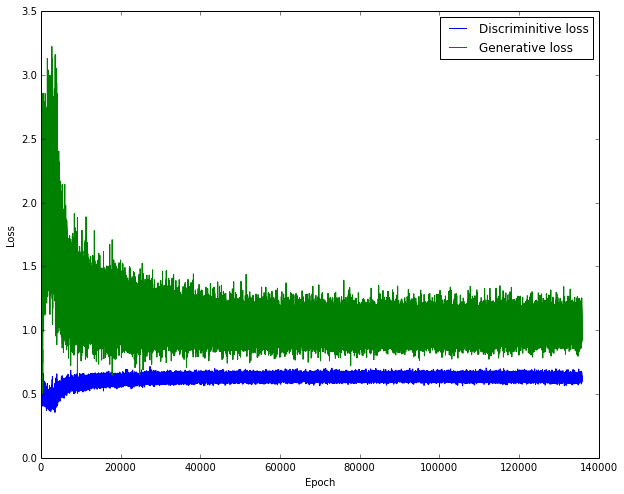

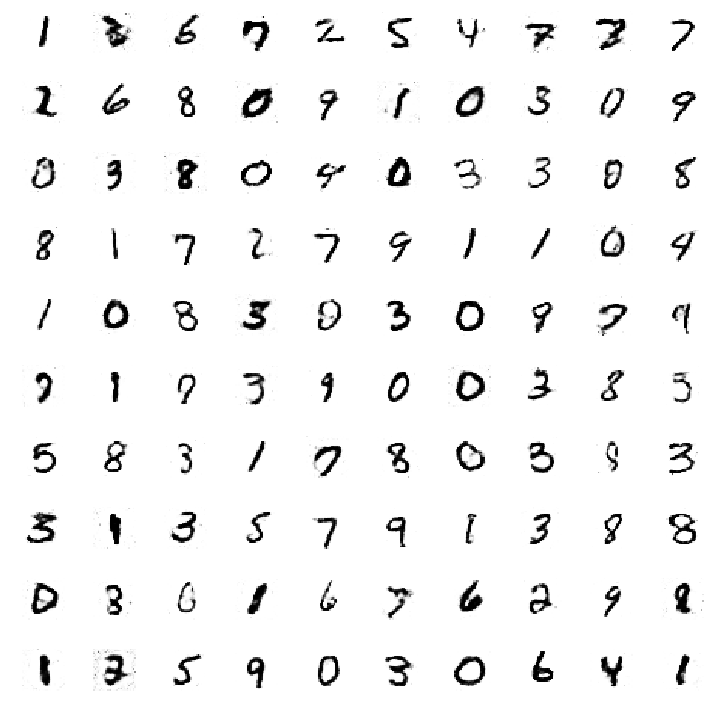

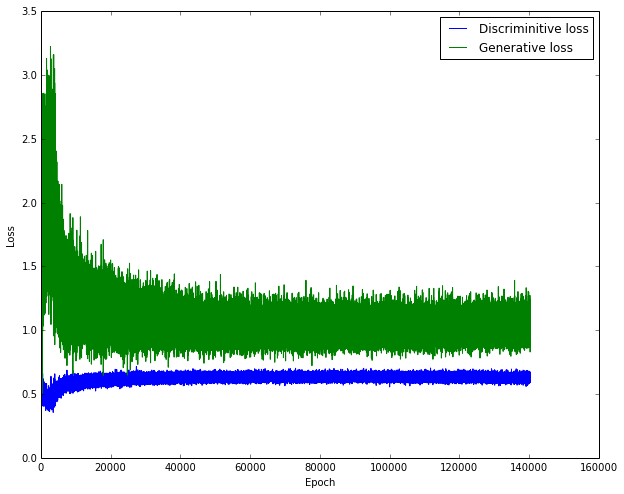

In [3]:
# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)


# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5) # learning rate 크기가 중요하다.

generator = Sequential()
generator.add(Dense(128, input_shape=(randomDim,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(256))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh')) # generator의 activation 함수는 tanh를 쓰는게 좋다.
generator.compile(loss='binary_crossentropy', optimizer=adam) # GAN에서 optimizer는 adam이 좋다.


discriminator = Sequential()
discriminator.add(Dense(512, input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid')) # discriminator의 activation 함수는 sigmoid를 사용한다.
discriminator.compile(loss='binary_crossentropy', optimizer=adam) # GAN에서 opimizer는 adam이 좋다.

# Combined network
discriminator.trainable = False # 처음에는 false로 두고, 나중에 학습하면서 true/false를 번갈아간다.
ganInput = Input(shape=(randomDim,))
x = generator(ganInput) # generator의 input은 noise 데이터이다.
ganOutput = discriminator(x) # discriminator의 input은 generator의 output이다.
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    if epoch % 10 == 0:
        plt.figure(figsize=(10, 8))
        plt.plot(dLosses, label='Discriminitive loss')
        plt.plot(gLosses, label='Generative loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    if epoch % 10 == 0:
        #print '-'*15, 'Epoch %d' % epoch, '-'*15
        noise = np.random.normal(0, 1, size=[examples, randomDim])
        generatedImages = generator.predict(noise)
        generatedImages = generatedImages.reshape(examples, 28, 28)

        plt.figure(figsize=figsize)
        for i in range(generatedImages.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)


def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print 'Epochs:', epochs
    print 'Batch size:', batchSize
    print 'Batches per epoch:', batchCount

    for e in xrange(1, epochs+1):
        #print '-'*15, 'Epoch %d' % e, '-'*15
        for _ in tqdm(xrange(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9 # 1보다는 0.9를 하는게 좋다.? (0보다는 0.1을 하는게 좋다?)

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

            # Store loss 
            dLosses.append(dloss)
            gLosses.append(gloss)

        plotGeneratedImages(e)
        plotLoss(e)

if __name__ == '__main__':
    train(300, 128) # increase epochs to get more clear images
